In [82]:
# Import Library
#%reset
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import keras
from glob import glob
from keras.preprocessing.image import ImageDataGenerator #, img_to_array, 
from tensorflow.keras.utils import img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
import os
import pickle
import warnings
warnings.filterwarnings("ignore")
from PIL import Image

#Usare scaler

# Prepare and Review Dataset

In [83]:
# Test and Train path
with open('./pickles/newResa3.pickle', 'rb') as handle:
    newResa3 = pickle.load(handle)

with open('./pickles/AllPixelBand3.pickle', 'rb') as handle:
    allPixel3 = pickle.load(handle)

# Identificare qualita' e suddivisione del dataset in maniera corretta tra train e test

 Low yield: 58 Medium yield[4500,10000]: 1472High yield(>10000): 31


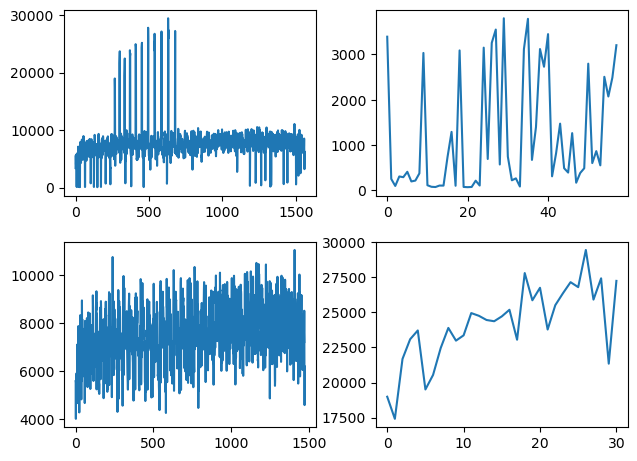

In [84]:
#taglio outliar
FilterResa3gtZero = newResa3!=0
newResa3 = newResa3[FilterResa3gtZero]
allPixel3 = allPixel3[FilterResa3gtZero,:,:]

LowValue = 1
Medium = 4000
HighValue = 12000
Resa3LowFilter = (newResa3<Medium) & (newResa3>LowValue)
Resa3MediumFilter = (newResa3>=Medium) & (newResa3<=HighValue)
Resa3HighFilter = (newResa3>HighValue)

Resa3Low = newResa3[Resa3LowFilter]
Resa3Medium = newResa3[Resa3MediumFilter]
Resa3High = newResa3[Resa3HighFilter]

Pixel3Low = allPixel3[Resa3LowFilter,:,:]
Pixel3Medium = allPixel3[Resa3MediumFilter,:,:]
Pixel3High = allPixel3[Resa3HighFilter,:,:]


print(" Low yield: "+str(len(Resa3Low))+ " Medium yield[4500,10000]: "+ str(len(Resa3Medium))+ "High yield(>10000): "+ str(len(Resa3High)))

padding = 1.2
f, axarr = plt.subplots(2,2)
f.tight_layout(pad=padding)
axarr[0][0].plot(newResa3)
axarr[0][1].plot(Resa3Low)
axarr[1][0].plot(Resa3Medium)
axarr[1][1].plot(Resa3High)
plt.show()

In [85]:
Resa3Medium = Resa3Medium/Resa3Medium.max()
Pixel3Medium = Pixel3Medium/Pixel3Medium.max()

In [86]:
def ResaIdeale(ndviPicco,rumore):  
    ideale = ((ndviPicco**1.6)/2.3)+0.4
    return np.random.normal(loc=ideale, scale=rumore, size=None)

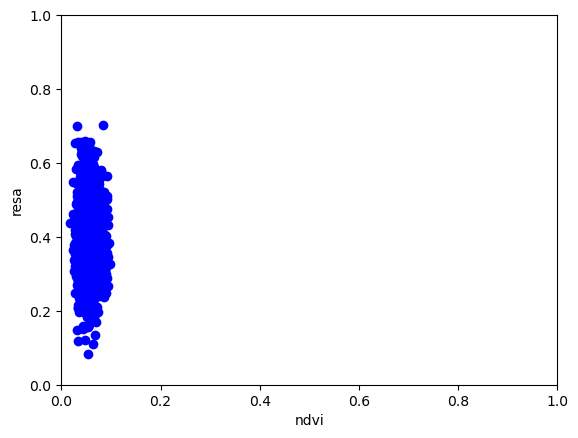

In [87]:
NVDI3Medium = (Pixel3Medium[:,7,:] - Pixel3Medium[:,3,:])/(Pixel3Medium[:,7,:] + Pixel3Medium[:,3,:])
Resa3MediumFake = []
noise = 0.1 #standard deviation
# noise a 0.1 is very similar to original dataset distribution

for v in (NVDI3Medium[:,12]):
    Resa3MediumFake.append(ResaIdeale(v,noise))

Resa3MediumFake = np.array(Resa3MediumFake)
fig, ax = plt.subplots()
ax.scatter(NVDI3Medium[:,12], Resa3MediumFake, c='blue')
ax.set_xlabel("ndvi")
ax.set_ylabel("resa")
ax.set_ylim([0,1])
ax.set_xlim([0,1])
plt.show()

# Split test set and train set

In [88]:
def splitSet(X,Y):
    if X.shape[0] != Y.shape[0]:
        raise Exception("X and Y have different sizes")
    choice = np.random.choice(range(X.shape[0]), size=(int(X.shape[0]/2),), replace=False)
    ind = np.zeros(X.shape[0], dtype=bool)
    ind[choice] = True
    rest = ~ind
    return np.array(X[ind,:,:]),np.array(Y[ind]),np.array(X[rest,:,:]),np.array(Y[rest])

[0.6320499  0.71325016 0.4654555  0.6128344  0.5161786  0.47504517
 0.7135485  0.67115873 0.67381597 0.70984274]


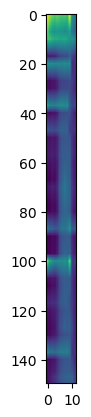

In [89]:
# Test and Train path
train_path = "dataset\\train\\"
test_path = "dataset\\test\\"

training_setMediumX,training_setMediumY, test_setMediumX, test_setMediumY = splitSet(Pixel3Medium,Resa3Medium)

training_setX = training_setMediumX
training_setY = training_setMediumY
test_setX = test_setMediumX
test_setY = test_setMediumY

print(training_setY[10:20])
plt.imshow(np.transpose(training_setX[0,:,:]))



In [90]:
print(training_setMediumX.shape)

(736, 12, 150)


# Image augmentation

In [91]:
def multiplyImg(img):
    newImg = np.concatenate((img,img,img,img,img,img),axis = 1)
    newImg = np.stack([newImg,newImg,newImg], axis=3)
    return newImg

In [92]:
print(training_setMediumX.shape)

(736, 12, 150)


(72, 150)


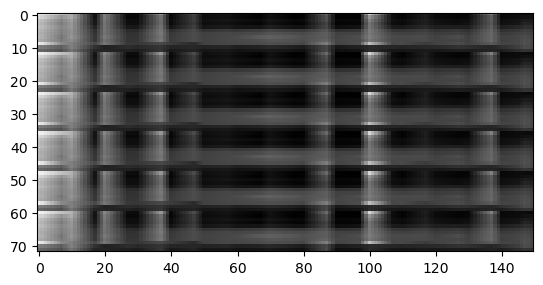

In [93]:

training_setMediumX = multiplyImg(training_setMediumX)
test_setMediumX = multiplyImg(test_setMediumX)
inputSize = training_setMediumX.shape[1:3]
print(inputSize)
plt.imshow(training_setMediumX[0])

# Creation of VGG16 model

In [94]:
# Import model
vgg16 = VGG16(input_shape=inputSize+(3,),include_top=False)


In [95]:
# add the layers of vgg16 in my created model.
vgg16Model = Sequential()
for i in range(len(vgg16.layers)-1):
    vgg16Model.add(vgg16.layers[i])


In [96]:
# Close the layers of vgg16
for layers in vgg16Model.layers:
    layers.trainable = False

In [97]:

# Last layer
vgg16Model.add(Flatten())
vgg16Model.add(Dense(2048,activation='relu',name='fc1'))
vgg16Model.add(Dense(1024,activation='relu',name='fc2'))
vgg16Model.add(Dense(1,activation='linear'))

In [98]:
# After I added last layer in created model.
vgg16Model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 72, 150, 64)       1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 72, 150, 64)       36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 36, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 36, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 36, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 37, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 18, 37, 256)      

In [99]:
# I create compile part.
vgg16Model.compile(loss = "mean_squared_error",
             optimizer = 'adam',
             metrics = ["mse","mae"])

# Training Model 

In [100]:
# Traning with model
batch_size = 32
#training_setMediumY, test_setMediumX, test_setMediumY
hist_vgg16 = vgg16Model.fit(x=training_setMediumX,y=training_setMediumY,
                                epochs = 25,
                                validation_data=(test_setMediumX,test_setMediumY)
                                )

Epoch 1/25
23/23 [==============================] - 41s 2s/step - loss: 59.4007 - mse: 59.4007 - mae: 3.3697 - val_loss: 0.1749 - val_mse: 0.1749 - val_mae: 0.4039
Epoch 2/25
23/23 [==============================] - 45s 2s/step - loss: 0.2298 - mse: 0.2298 - mae: 0.3990 - val_loss: 0.1021 - val_mse: 0.1021 - val_mae: 0.3024
Epoch 3/25
23/23 [==============================] - 46s 2s/step - loss: 0.0267 - mse: 0.0267 - mae: 0.1335 - val_loss: 0.0115 - val_mse: 0.0115 - val_mae: 0.0876
Epoch 4/25
23/23 [==============================] - 46s 2s/step - loss: 0.0114 - mse: 0.0114 - mae: 0.0840 - val_loss: 0.0112 - val_mse: 0.0112 - val_mae: 0.0864
Epoch 5/25
23/23 [==============================] - 48s 2s/step - loss: 0.0092 - mse: 0.0092 - mae: 0.0764 - val_loss: 0.0094 - val_mse: 0.0094 - val_mae: 0.0753
Epoch 6/25
23/23 [==============================] - 48s 2s/step - loss: 0.0094 - mse: 0.0094 - mae: 0.0764 - val_loss: 0.0093 - val_mse: 0.0093 - val_mae: 0.0780
Epoch 7/25
23/23 [========

In [101]:
# Save the weights of model
vgg16Model.save_weights("previsioneOttima.h5")

# Plot the result of the network

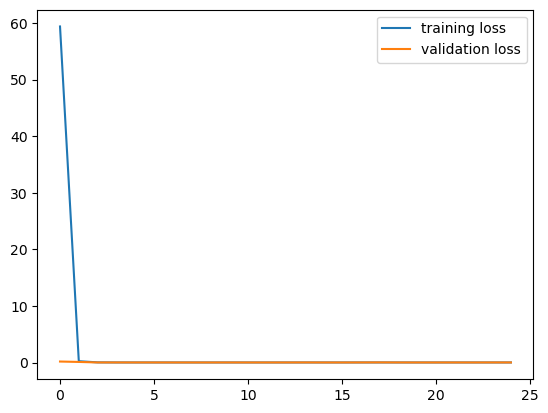

In [102]:
# Loss and Validation Loss
plt.plot(hist_vgg16.history["loss"], label = "training loss")
plt.plot(hist_vgg16.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

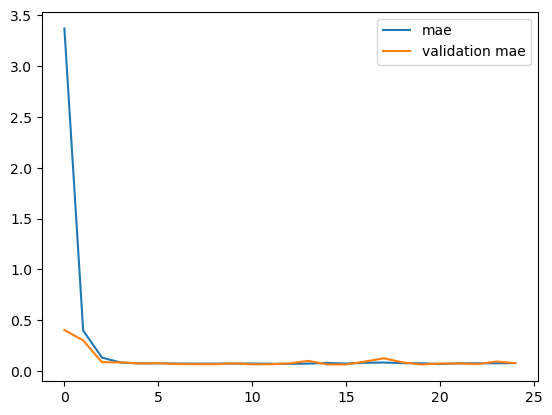

In [103]:
# Accuracy and Validation Accuracy
plt.plot(hist_vgg16.history["mae"], label = "mae")
plt.plot(hist_vgg16.history["val_mae"], label = "validation mae")
plt.legend()
plt.show()

In [104]:
true_y = test_setMediumY
print(len(true_y))
pred_y = vgg16Model.predict(test_setMediumX)

736
23/23 [==============================] - 21s 908ms/step


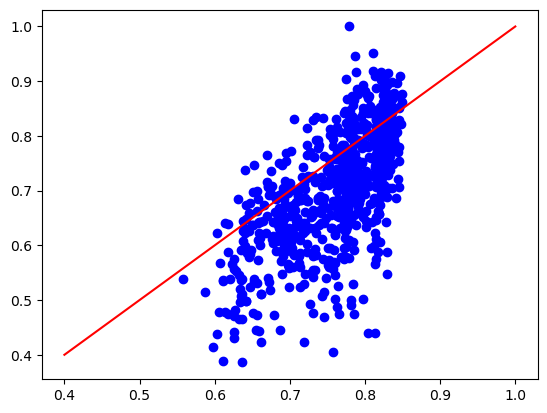

In [105]:

import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots()
ax.scatter(pred_y, true_y, c='blue')
line = mlines.Line2D([0.4, 1], [0.4, 1], color='red')
transform = ax.transAxes
ax.add_line(line)
plt.show()


# Calculate the metrics

In [106]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

predizione = pred_y
present = true_y


# calculate MAE
error1 = np.round(mae(true_y, pred_y),6)
print("Mean absolute error : " + str(error1))

# calculate MSE
error2 = round(mse(present, predizione),6)
print("Mean Square error : " + str(error2))
# calculate RMSE
print("R - Mean Square error : " + str(np.round(np.sqrt(error2),6)))

Mean absolute error : 0.079033
Mean Square error : 0.010294
R - Mean Square error : 0.101459


# Save the result

In [107]:
import json, codecs
with open("previsioneResa.json","w") as f:
    json.dump(hist_vgg16.history, f)

In [108]:
'''with codecs.open("./previsioneResa.json","r", encoding = "utf-8") as f:
    load_result = json.loads(f.read())'''

'with codecs.open("./previsioneResa.json","r", encoding = "utf-8") as f:\n    load_result = json.loads(f.read())'

# Vgg19

In [109]:
# Import VGG19 model
vgg19 = VGG19(input_shape=inputSize+(3,),include_top=False)

In [110]:
# Layers of vgg19
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 72, 150, 3)]      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 72, 150, 64)       1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 72, 150, 64)       36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 36, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 36, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 36, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 37, 128)       0     

In [111]:
# add the layers of vgg16 in my created model.
vgg19Model = Sequential()
vgg19Model.add(vgg19)

In [112]:
# Close the layers of vgg16
for layers in vgg19Model.layers:
    layers.trainable = False

In [113]:
# Last layer
vgg19Model.add(Flatten())
vgg19Model.add(Dense(2048,activation='relu',name='fc1'))
vgg19Model.add(Dense(1024,activation='relu',name='fc2'))
vgg19Model.add(Dense(1,activation='linear'))

In [114]:
# the final version of the model
vgg19Model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 4, 512)         20024384  
                                                                 
 flatten_15 (Flatten)        (None, 4096)              0         
                                                                 
 fc1 (Dense)                 (None, 2048)              8390656   
                                                                 
 fc2 (Dense)                 (None, 1024)              2098176   
                                                                 
 dense_4 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 30,514,241
Trainable params: 10,489,857
Non-trainable params: 20,024,384
_________________________________________________________________


In [115]:
# compile the model
vgg19Model.compile(loss = "mean_squared_error",
             optimizer = "adam",
             metrics = ["mse","mae"])

# Training

In [116]:
# Training with my created model
hisy_vgg19 = vgg19Model.fit(x=training_setMediumX,y=training_setMediumY,
                                epochs = 30,
                                validation_data=(test_setMediumX,test_setMediumY)
                               )

Epoch 1/30
23/23 [==============================] - 54s 2s/step - loss: 16.7486 - mse: 16.7486 - mae: 1.7694 - val_loss: 0.1654 - val_mse: 0.1654 - val_mae: 0.3908
Epoch 2/30
23/23 [==============================] - 52s 2s/step - loss: 0.0558 - mse: 0.0558 - mae: 0.1966 - val_loss: 0.0128 - val_mse: 0.0128 - val_mae: 0.0922
Epoch 3/30
23/23 [==============================] - 43s 2s/step - loss: 0.0180 - mse: 0.0180 - mae: 0.1093 - val_loss: 0.0117 - val_mse: 0.0117 - val_mae: 0.0854
Epoch 4/30
23/23 [==============================] - 48s 2s/step - loss: 0.0139 - mse: 0.0139 - mae: 0.0941 - val_loss: 0.0130 - val_mse: 0.0130 - val_mae: 0.0936
Epoch 5/30
23/23 [==============================] - 48s 2s/step - loss: 0.0100 - mse: 0.0100 - mae: 0.0796 - val_loss: 0.0118 - val_mse: 0.0118 - val_mae: 0.0855
Epoch 6/30
23/23 [==============================] - 43s 2s/step - loss: 0.0100 - mse: 0.0100 - mae: 0.0795 - val_loss: 0.0126 - val_mse: 0.0126 - val_mae: 0.0884
Epoch 7/30
23/23 [========

# Plot the result of the network

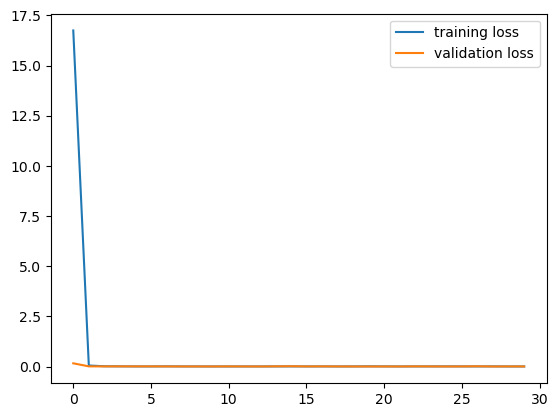

In [117]:
# Loss And Validation Loss
plt.plot(hisy_vgg19.history["loss"], label = "training loss")
plt.plot(hisy_vgg19.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

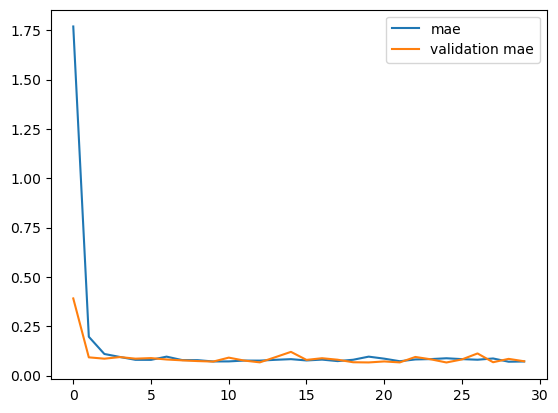

In [118]:
# Accuracy And Validation Accuracy
plt.plot(hisy_vgg19.history["mae"], label = "mae")
plt.plot(hisy_vgg19.history["val_mae"], label = "validation mae")
plt.legend()
plt.show()

In [119]:
true_y = test_setMediumY
print(len(true_y)) 
pred_y = vgg19Model.predict(test_setMediumX)

736
23/23 [==============================] - 21s 900ms/step


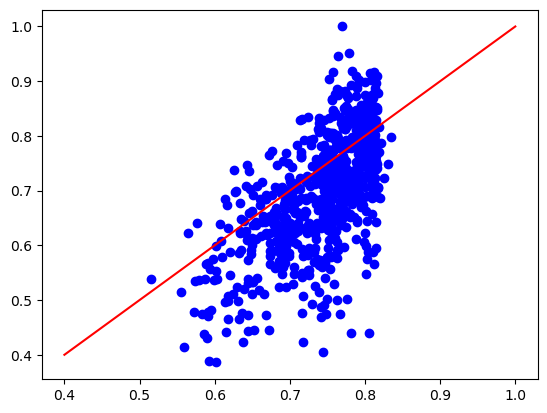

In [120]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

#
#lineStart = data_calc_hourly.temp.min() 
#lineEnd = data_calc_hourly.temp.max()  
fig, ax = plt.subplots()
ax.scatter(pred_y, true_y, c='blue')
line = mlines.Line2D([0.4, 1], [0.4, 1], color='red')
transform = ax.transAxes
#line.set_transform(transform)
ax.add_line(line)
plt.show()                      

# Calculate the metrics

In [121]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

predizione = pred_y
present = true_y


# calculate MAE
error1 = np.round(mae(true_y, pred_y),6)
print("Mean absolute error : " + str(error1))

# calculate MSE
error2 = round(mse(present, predizione),6)
print("Mean Square error : " + str(error2))
# calculate RMSE
print("R - Mean Square error : " + str(np.round(np.sqrt(error2),6)))

Mean absolute error : 0.072256
Mean Square error : 0.008738
R - Mean Square error : 0.093477


In [122]:
# Save the weights of model
vgg19Model.save_weights("previsioneOttimavgg19.h5")
import json, codecs
with open("previsioneResavgg19.json","w") as f:
    json.dump(hisy_vgg19.history, f)